In [1]:
# !AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [2]:
import time
import torch
import threading
import numpy as np
from collections import deque
from make_model import make_model
from matplotlib import pyplot as plt
from tokenizer import tokenizer,token2str,vocab_size
from train_and_use import Batch,CrossEntropyLoss,SimpleMoOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP,SET_CACULATE_SIZE
from train_and_use import record
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# %matplotlib widget

In [3]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 768,
    key_dim = 128,
    head_number = 12,
    position_information_type = "mask",
    # position_information_type = "sinusoidal",
    # position_information_type = "rotary",
    # position_information_type = "learned",
    enable_affine = True,
    enable_talking_head = True,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 1536,
    enable_layer_norm = True,
    deep = 12,
    dropout_rate = 0.1
).to(device)
parameters_n = 0
for p in model.parameters():
    parameters_n += p.data.cpu().numpy().size
print("模型参数量:"+str(parameters_n/1e9)[:4]+"(B)")

模型参数量:0.18(B)


In [4]:
#数据量
# [num,batch,length]
# [407284,32,2000]
batch_size_adjust = 0
seq_len = 64
total_lines = 13033101
skip = 3394806
cnt = 0
buffer = deque()
#源源不断的产生分好词的数据
def auto_tokenizer():
    global buffer
    global cnt
    with open('high_data.txt','r') as f:
        for line in f:
            #快速跳过历史
            if cnt < skip:
                cnt += 1
                continue
            buffer.append(tokenizer(line,5.0))
            cnt += 1
            #缓存的句子大小
            while len(buffer) > 2048:
                time.sleep(1)
#将分好词的数据自合成训练的批次
def data_generator(batch_size):
    global buffer
    global batch_size_adjust
    thread = threading.Thread(target=auto_tokenizer)
    thread.start()
    while len(buffer) == 0:
        time.sleep(1)
    stop = batch_size+batch_size_adjust
    data = []
    while len(buffer):
        temp = buffer.popleft()
        while len(temp) > seq_len // 2:
            data += [temp[:seq_len]]
            temp = temp[seq_len:]
            if len(data)==stop:#一个批次产出一次
                stop = batch_size+batch_size_adjust
                trunk = sorted(data,key = lambda token_list:len(token_list),reverse = True)
                trunk = [(s + [-255]*len(trunk[0]))[:min(len(trunk[0]),seq_len)] for s in trunk]
                trunk = np.array(trunk,dtype=np.int64)+255
                inputs = torch.from_numpy(trunk).to(device).data
                data = []
                print('\r{:.4f}'.format(cnt*100/total_lines),end='% ')
                yield Batch(inputs)

In [5]:
#改完参数需要检查，否则优化器可能匹配错
def get_info(p_cnt,p):
    if p_cnt==0 or p.dim()==1:
        ret = 'vector'
    elif (p_cnt-1)%25 in [2,3,4] and p_cnt < 25*12:
        ret = 12,128,768
    elif p.dim()==2:
        ret = 'matrix'
    return ret

In [6]:
# #检查对应关系是否正确
# for i,p in enumerate(model.parameters()):
#     print(i,p.size(),get_info(i,p))

In [7]:
record['loss_line'] = list(np.load('loss_line.npy'))
record['lr_line'] = list(np.load('lr_line.npy'))

In [8]:
model.load_state_dict(torch.load('large_model_3394806.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
optimizer = OptimizerWrapper(
    optimizer = SimpleMoOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7,weight_decay=0.1,get_info=get_info),
    warm_up = 2048,
    lr = 3e-4,
    enable_wave = True
)
batch_size = 1024
caculate_size = 64
train_server_start(model,(data_generator,batch_size),caculate_size,loss_f,optimizer,use_amp = False)

27.2768% 	step: 2446 	loss: 4.284 	speed: 17990.7 tokens/s                    

In [1135]:
!nvidia-smi

Mon Mar 17 18:51:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:00:08.0 Off |                  Off |
| 87%   66C    P2            387W /  450W |   15518MiB /  24564MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1174]:
print('\r{:.4f}'.format(cnt*100/total_lines),end='% ')

99.9996% 

In [1173]:
TOGGLE()
# STOP()

pause: True


In [961]:
torch.cuda.empty_cache()

# SET_CACULATE_SIZE(32)
# seq_len = 128
# batch_size_adjust = 512 - 1024

# SET_CACULATE_SIZE(16)
# seq_len = 256
# batch_size_adjust = 256 - 1024

# SET_CACULATE_SIZE(4)
# seq_len = 512
# batch_size_adjust = 128 - 1024

# optimizer.set_lrate(6e-5,8192)
# optimizer.enable_wave = False
# batch_size_adjust = 256 - 1024

SET_CACULATE_SIZE(2)
seq_len = 1024
batch_size_adjust = 128 - 1024
optimizer.set_lrate(1e-5,8192)
optimizer.enable_wave = False

In [1071]:
optimizer.enable_wave = False

In [697]:
# def Msign_1(M):
#     U,S,Vh = torch.linalg.svd(M,full_matrices=True)
#     return U[...,:S.size(-1)]@Vh[...,:S.size(-1)]
    
# def Msign_2(G, steps=10,eps=1e-7):
#     a,b,c = (3.4445,-4.7750,2.0315)
#     # a,b,c = (15/8,-5/4,3/8)
#     X = G/(G.norm() + eps)
#     if G.size(-2) > G.size(-1):
#         X = X.transpose(-1,-2)
#     for _ in range(steps):
#         A = X @ X.transpose(-1,-2)
#         B = b * A + c * A @ A
#         X = a * X + B @ X
#     if G.size(-2) > G.size(-1):
#         X = X.transpose(-1,-2)
#     return X

In [696]:
# L = 12
# T = torch.randn(L,L)
# U,S,Vh = torch.linalg.svd(T,full_matrices=True)

In [695]:
# (U.T @ Msign_2(T,steps=10) @ Vh.T - torch.eye(L)).var()

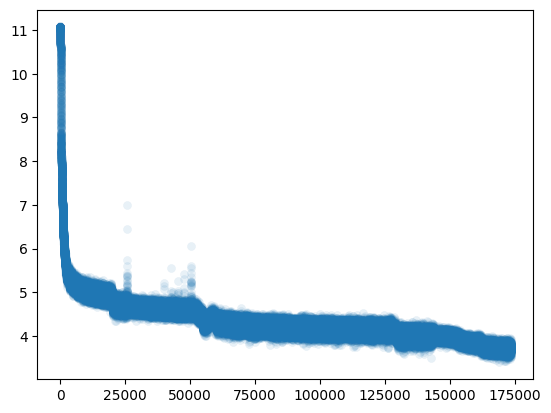

In [1175]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.yscale('log')
# plt.plot(record['loss_line'])
plt.show()

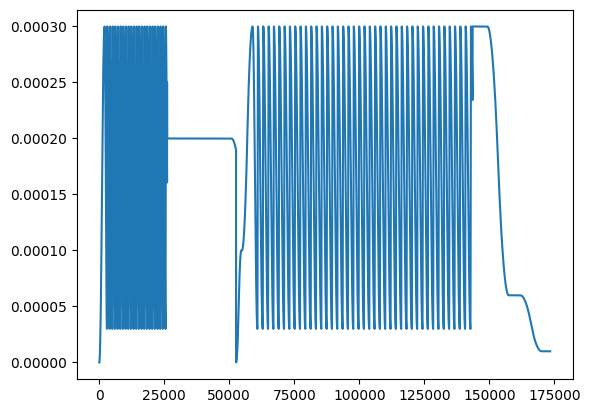

In [1176]:
plt.close()
# plt.plot(record['loss_line'])
plt.plot(record['lr_line'])
plt.show()

In [1182]:
tokens_batch = [tokenizer("什么是光合作用？",5.0)]
tokens_batch = np.array(tokens_batch,dtype=np.int64)+255
inputs = torch.from_numpy(tokens_batch).to(device).data
model = model.eval()
with torch.no_grad():
    o = text_continue(
        model,inputs,out_length=256,
        repeat_penalty_value = 0.0,
        temperature = 0.1,
        decay = 1.0
    )
print(token2str(o[0].cpu().numpy()-255))
model = model.train()

什么是光合作用？ 光合作用,又称光合反应,是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物在光合作用下,将二氧化碳转化为水的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物在光合作用下,将二氧化碳转化为水的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物在光合作用下,将二氧化碳转化为水的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为氧气的过程。 光合作用是绿色植物通过光合作用将二氧化碳转化为


In [1177]:
torch.save(model.state_dict(),'large_model_'+str(cnt)+'.weight')

In [1178]:
np.save('loss_line',record['loss_line'])
np.save('lr_line',record['lr_line'])